# Florian Ellsäßer: Using a LSTM network and SHAP to determine the impact of drought and season on winter wheat

[Presentation](http://spatial-ecology.net/docs/source/STUDENTSPROJECTS/Proj_2022_Matera/Using_a_LSTM_network_and_SHAP_to_determine_the_impact_of_drought_Florian_Ellsäßer.pdf)  
[Video Recording](https://youtu.be/EqxW-PfZsKY)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy 
import datetime as dt
#import rioxarray as rio
import matplotlib.pyplot as plt
%matplotlib inline

## load the data

In [2]:
# load the data
spei_data = xr.open_dataset(r'C:\Users\Florian\Desktop\Jupyter_Skripts\05_ML_crop_vulnerability\data/spei01_germany.nc')
yield_data = xr.open_dataset(r'C:\Users\Florian\Desktop\Jupyter_Skripts\05_ML_crop_vulnerability\data/all_crops_productivity_gapfilled_detrended.nc4')
yield_index_data = xr.open_dataset(r'C:\Users\Florian\JLUbox\Erntedaten_CROP_Projekt\09_Final_output_files/all_crops_SHI.nc4')
natural_areas_raster = xr.open_dataset('C:/Users/Florian/Desktop/E-OBS_data_25.0e/natural_areas_germany.nc')
phen_data_winterwheat = pd.read_csv('C:/Users/Florian/Desktop/CROP_indices_data/phen_data_gapfilled.csv')

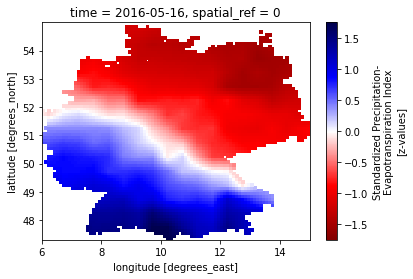

In [3]:
# visualize the data for a quick check
spei_data.spei.sel(time='2016-05-16T00:00:00.000000000').plot(cmap='seismic_r')

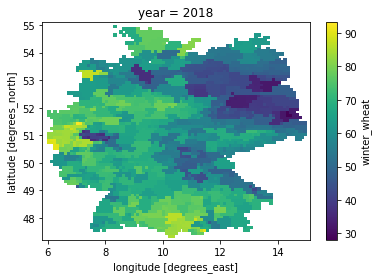

In [4]:
yield_data.winter_wheat.sel(year=2018).plot()

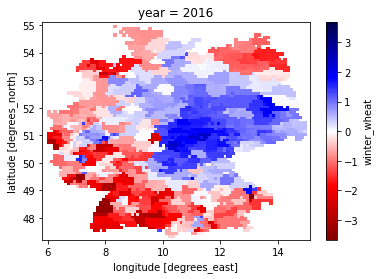

In [5]:
yield_index_data.winter_wheat.sel(year=2016).plot(cmap='seismic_r')

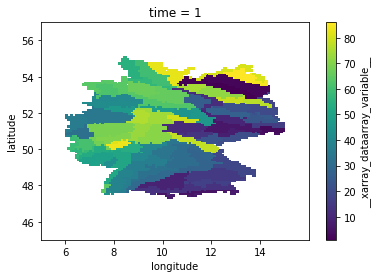

In [6]:
natural_areas_raster = natural_areas_raster.__xarray_dataarray_variable__
natural_areas_raster = natural_areas_raster.where(natural_areas_raster != -9999.)  
natural_areas_raster.plot()

## align the data properties

In [7]:
# get the same order of dimensions 
# rename year to time in yield data 
yield_data = yield_data.rename({'year':'time'})
yield_index = yield_index_data.winter_wheat.rename({'year':'time'})

# transpose dimensions of 
spei_data['spei'] = spei_data.spei.transpose('longitude','latitude','time')

In [8]:
# create a function to round coordinates (this is taken from the crops package)
def round_coordinates(in_array):
    """
        This function rounds the coordinates two two decimals. This prevents errors
        due to weird roundings that sometimes appear
        
        Parameters:
            in_array (xarray.core.dataarray.DataArray) = input Data array e.g. Tmax
            
        Returns:
            in_array (xarray.core.dataarray.DataArray) = array with rounded coordinates
    """
    
    # round longitude
    in_array.coords['longitude'] = np.round(in_array.coords['longitude'],2)
    # round latitude    
    in_array.coords['latitude'] = np.round(in_array.coords['latitude'],2)
    
    return in_array

In [9]:
print(yield_data.dims)
print(yield_index.dims)
print(spei_data.dims)

Frozen(SortedKeysDict({'latitude': 79, 'longitude': 93, 'time': 32}))
('latitude', 'longitude', 'time')
Frozen(SortedKeysDict({'longitude': 90, 'latitude': 77, 'time': 852}))


In [10]:
spei_data = round_coordinates(spei_data)
yield_data = round_coordinates(yield_data)
yield_index = round_coordinates(yield_index)
natural_areas_raster = round_coordinates(natural_areas_raster)

In [11]:
# now dims are the same, adjust the extend of the lon and lat dims
# get the dims of the smaller xarray
min_lon = spei_data.longitude.min()
min_lat = spei_data.latitude.min()
max_lon = spei_data.longitude.max()
max_lat = spei_data.latitude.max()
#create a mask for later
mask_lon_spei_data = (spei_data.longitude >= min_lon) & (spei_data.longitude <= max_lon)
mask_lat_spei_data = (spei_data.latitude >= min_lat) & (spei_data.latitude <= max_lat)
# now drop the coords that are too big
yield_data = yield_data.where(mask_lon_spei_data.longitude, drop=True)
yield_data = yield_data.where(mask_lat_spei_data.latitude, drop=True)

yield_index = yield_index.where(mask_lon_spei_data.longitude, drop=True)
yield_index = yield_index.where(mask_lat_spei_data.latitude, drop=True)

natural_areas_raster = natural_areas_raster.where(mask_lon_spei_data.longitude, drop=True)
natural_areas_raster = natural_areas_raster.where(mask_lat_spei_data.latitude, drop=True)

# transpose again
spei_data['spei'] = spei_data.spei.transpose('latitude','longitude','time')
#yield_data = yield_data.transpose('longitude','latitude','time')

In [12]:
print(yield_data.dims)
print(yield_index.dims)
print(spei_data.dims)

Frozen(SortedKeysDict({'latitude': 77, 'longitude': 90, 'time': 32}))
('latitude', 'longitude', 'time')
Frozen(SortedKeysDict({'latitude': 77, 'longitude': 90, 'time': 852}))


In [13]:
# concatenate the data into one set
in_data = xr.concat([natural_areas_raster,yield_data.winter_wheat,yield_index,spei_data.spei], dim='time')

## apply ufunc to go through the raster cells 

In [ ]:
## use apply ufunc to go through the xarrays along the time coordinate
# the purpose of this is to create a list of lists that can later be converted into a pandas data frame
# for each harvest date, we want the previous 24 month of SPEI data
test_list = []
test_list.append(['harvest_year','harvest_month','natural_area','yield','index']+
                ['SPEI'+str(i) for i in range(1,25)])
# first we create a yield_calculation class and a function to return the three best years
class calcualte_impact:
    def __init__(self,in_time):
        self.in_time = in_time
        pass
        
    # now define a function that takes the yield data and returns the three best years            
    def run_model(self, in_data):
        # first get the times
        in_time_index = self.in_time[1:33]
        in_time_yield = self.in_time[33:65]
        in_time_spei = self.in_time[65:]
        # the get the data
        natural_area = in_data[0]
        index_data = in_data[1:33]
        yield_data = in_data[33:65]
        spei_data = in_data[65:]
        
        if np.isnan(spei_data).all():
            # create a list with the length of  total_years_in_data full of Nones
            result = [None] * len(index_data)
            return np.array(result)
        
        else:
            # create a pandas dataframe from in_time_yield and yield_data
            yield_df = pd.DataFrame({'time': in_time_yield, 'yield': yield_data, 'index':index_data}, 
                                    columns=['time', 'yield','index'])
            # add a column for the harvest dates
            yield_df['natural_area'] = [natural_area]*len(index_data)
            harvest_date_list = []
            for year in in_time_yield:
                try: 
                    harvest_date = phen_data_winterwheat[(phen_data_winterwheat.natural_area_group_code == natural_area) &
                             (phen_data_winterwheat.reference_year == int(year))]['start_date'].values[0]
                    harvest_date_list.append(harvest_date)
                except: 
                    harvest_date_list.append(None)
                      
            # add the harvest date to the df
            yield_df['harvest_date'] = harvest_date_list
            # convert the time strings to datetime objects
            yield_df['harvest_date'] = yield_df['harvest_date'].astype('datetime64[ns]')
            # convert the time strings to datetime objects
            yield_df['harvest_date'] = yield_df['harvest_date'].astype('datetime64[ns]')
            yield_df['harvest_date'] = pd.to_datetime(yield_df['harvest_date']).apply(lambda x: x.date())
            # create a column for years and month
            yield_df['harvest_year'] = pd.DatetimeIndex(yield_df['harvest_date']).year
            yield_df['harvest_month'] = pd.DatetimeIndex(yield_df['harvest_date']).month
            
            # create the same for in_time spei and spei data
            spei_df = pd.DataFrame({'time': in_time_spei, 'spei': spei_data}, columns=['time', 'spei'])

            # convert the time strings to datetime objects
            spei_df['time'] = spei_df['time'].astype('datetime64[ns]')
            spei_df['time'] = pd.to_datetime(spei_df['time']).apply(lambda x: x.date())
            # create a column for years and month
            spei_df['year'] = pd.DatetimeIndex(spei_df['time']).year
            spei_df['month'] = pd.DatetimeIndex(spei_df['time']).month
            
            # now form an output for every year: year, harvest_month, natural_area, index, yield, 24 SPEI
            for index, row in yield_df.iterrows():    
                
                # get the SPEI for each harvest month
                index_df = spei_df[(spei_df.year==yield_df['harvest_year'][index])&
                       (spei_df.month==yield_df['harvest_month'][index])]
                
                
                try: 
                    new_index = index_df.index.values.astype('int')[0]
                    # create a range of indices +23
                    index_df_range = list(range(new_index,new_index+24)) 
                    spei_range = spei_df.iloc[index_df_range]['spei'].values
                except:
                    spei_range = [None]*24
                 
                
                # append all to a list
                test_list.append([yield_df['harvest_year'][index],
                                  yield_df['harvest_month'][index],
                                  yield_df['natural_area'][index],
                                  yield_df['index'][index],
                                  yield_df['yield'][index]]+
                                  # list(spei_range).reverse()
                                 list(spei_range)
                                 )
            return np.array(yield_df['harvest_month'])        
        
# now we create an object and give it the in_years of the yield data
yield_object = calcualte_impact(in_data.time)

# now we can apply ufunc and get the years with the highest productivity
test_out = xr.apply_ufunc(yield_object.run_model, 
                     in_data,
                     input_core_dims=[['time']],
                     output_core_dims=[['year']], 
                     dask = 'parallelized', 
                     vectorize = True)

In [ ]:
df = pd.DataFrame(test_list)
df.columns = df.iloc[0] 
df = df[1:]
df.head()

In [ ]:
# revove all the rows with a Nan
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df.to_csv('C:/Users/Florian/Desktop/Jupyter_Skripts/05_ML_crop_vulnerability/data/yield_spei_data.csv')

In [ ]:
df

## ML part

In [23]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import time
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

Using TensorFlow backend.
C:\Users\Florian\anaconda3\envs\yield_ml_2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Florian\anaconda3\envs\yield_ml_2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Florian\anaconda3\envs\yield_ml_2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Florian\anaconda3

In [24]:
# on LSTMs: https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/
# create data similar to this:
# based on this: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# X -> array([[10, 20, 30],
#       [20, 30, 40],
#       [30, 40, 50],
#       [40, 50, 60],
#       [50, 60, 70],
#       [60, 70, 80]])
# y -> array([40, 50, 60, 70, 80, 90])

In [25]:
# read the data again
df = pd.read_csv('C:/Users/Florian/Desktop/Jupyter_Skripts/05_ML_crop_vulnerability/data/yield_spei_data.csv')

### do with all data

In [26]:
# create X and y data
X = np.array(df[['SPEI1', 'SPEI2', 'SPEI3', 'SPEI4', 'SPEI5', 'SPEI6', 'SPEI7',
       'SPEI8', 'SPEI9', 'SPEI10', 'SPEI11', 'SPEI12', 'SPEI13', 'SPEI14',
       'SPEI15', 'SPEI16', 'SPEI17', 'SPEI18', 'SPEI19', 'SPEI20',
       'SPEI21', 'SPEI22', 'SPEI23', 'SPEI24']].values.tolist())
y = np.array(df['index'].values.tolist())

In [27]:
# create train and test data by splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [28]:
# define model
n_steps = 24 # --> month of SPEI
n_features = 1
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [29]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [30]:
# fit model -> outcommented because it takes like 4h
#model.fit(X_train, y_train, epochs=200, verbose=0)

In [31]:
# save the model
#model.save('C:/Users/Florian/Desktop/Jupyter_Skripts/05_ML_crop_vulnerability/models/model_v001')

In [32]:
# load the model again
model = keras.models.load_model('C:/Users/Florian/Desktop/Jupyter_Skripts/05_ML_crop_vulnerability/models/model_v001')

In [33]:
# test the model
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_pred = model.predict(X_test, verbose=0)
# reformat the output
y_pred_list = []
for item in y_pred:
    y_pred_list.append(item[0])
y_pred = y_pred_list

n predictions: 45036
slope: 1.0054949082304028
intercept: 0.01712772477690782
r: 0.9177724506004394
r²: 0.8423062710811361
p-value: 0.0
standard error: 0.002050131923845098


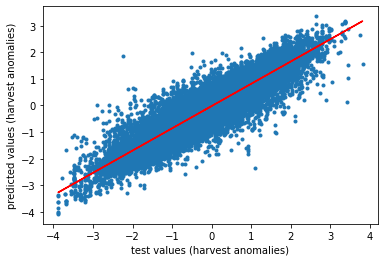

In [34]:
# plot it 
plt.scatter(y_test,y_pred, marker='.')
m, b = np.polyfit(y_test,y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')
plt.xlabel('test values (harvest anomalies)')
plt.ylabel('predicted values (harvest anomalies)')
# check all other things
n_pred = len(y_pred)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
print('n predictions: ' + str(n_pred))
print('slope: ' + str(slope))
print('intercept: ' + str(intercept))
print('r: ' + str(r_value))
print('r²: ' + str(r_value**2))
print('p-value: ' + str(p_value))
print('standard error: ' +str(std_err))
plt.savefig(r'C:\Users\Florian\Desktop\Jupyter_Skripts\05_ML_crop_vulnerability/figures/scatterplot.png', format='png', dpi=300, bbox_inches='tight')

## now implement shap for variable importance

In [35]:
import shap

C:\Users\Florian\anaconda3\envs\yield_ml_2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# create a smaller subset
test_images= X_test[100:110]
test_labels=y_test[100:110]

In [37]:
# fit the explainer
explainer = shap.DeepExplainer(model, X_test[0:4999])
shap_values = explainer.shap_values(test_images)

keras is no longer supported, please use tf.keras instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
# reformat output
shap_list=[]
for row in shap_values[0]:
    row_list = []
    for item in row:
        row_list.append(item[0])
    #print(row_list)
    shap_list.append(row_list)
# make it numpy array    
shap_array = np.array(shap_list)

In [39]:
# create a feature name list
feature_names = ['SPEI-24','SPEI-23','SPEI-22','SPEI-21','SPEI-20','SPEI-19',
                'SPEI-18','SPEI-17','SPEI-16','SPEI-15','SPEI-14','SPEI-13',
                'SPEI-12','SPEI-11','SPEI-10','SPEI-9','SPEI-8','SPEI-7',
                'SPEI-6','SPEI-5','SPEI-4','SPEI-3','SPEI-2','SPEI-1']

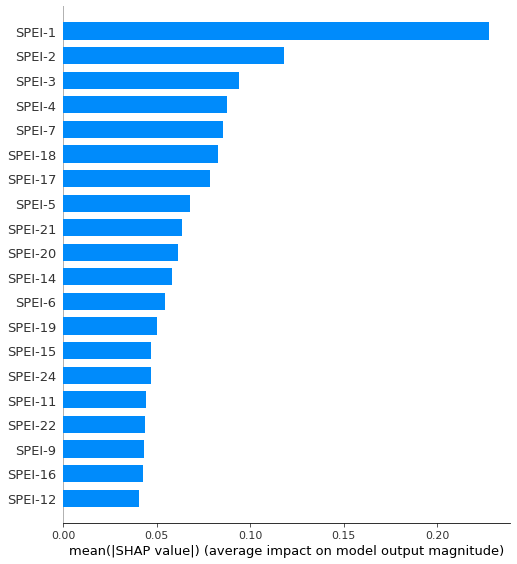

In [40]:
# plot and save the figure
shap.summary_plot(shap_array, plot_type = 'bar', feature_names = np.array(feature_names), show=False)
plt.savefig(r'C:\Users\Florian\Desktop\Jupyter_Skripts\05_ML_crop_vulnerability/figures/barplot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

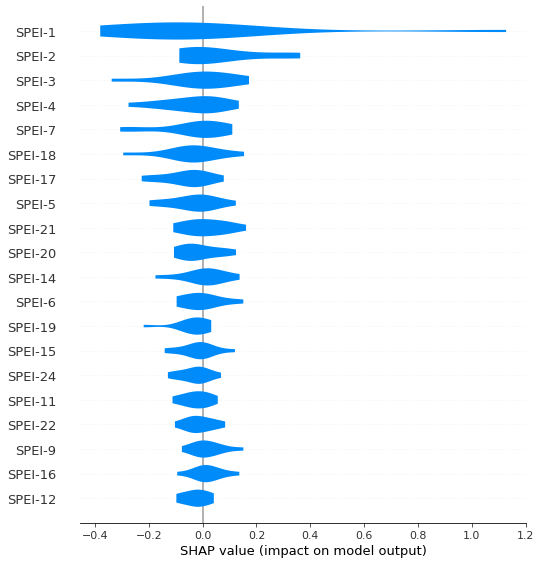

In [41]:
# plot and save the figure
shap.summary_plot(shap_array,feature_names = np.array(feature_names),plot_type='violin', show=False)
plt.savefig(r'C:\Users\Florian\Desktop\Jupyter_Skripts\05_ML_crop_vulnerability/figures/violinplot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()